In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
from scipy.optimize import curve_fit, minimize

codepath = "/Users/jasonwu/Programs/Research/gal_fesc"
import sys, os
sys.path.append(os.path.abspath(codepath))
from codes.plotting import plot_prettier
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(f'{codepath}/codes/def.mplstyle')
pi = np.pi
plot_prettier(usetex=True)

# Q1.1

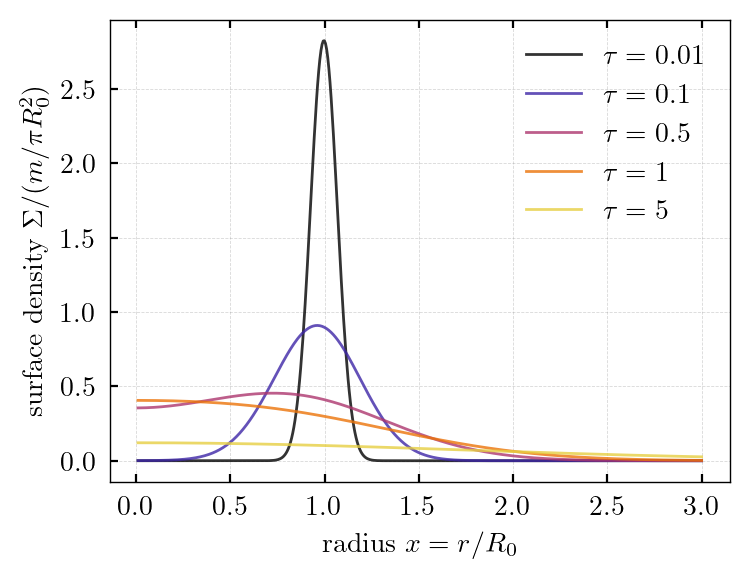

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# bessel function
from scipy.special import iv

def eq2_sigma(x, tau):
    """
    Sigma / (m / pi R_0^2) from eq (2)
    ---
    x: dimless radius r / R_0
    tau: dimless time (12 * nu / R_0^2) * t
    """
    # iv = modified Bessel function of the 1st kind
    bessel_func = iv(1/4, 2 * x / tau)
    sigma_dimless = (1 / ( tau * x**(1/4) ) ) *\
                    np.exp(-(1 + x**2) / tau) *\
                    bessel_func
    return sigma_dimless

# pick a few tau values
x = np.linspace(0.01, 3.0, 500)
taus = [0.01, 0.1, 0.5, 1, 5]


# make plot
fig, ax = plt.subplots(figsize=(4, 3))
colors = mpl.colormaps['CMRmap'](np.linspace(0, 1, len(taus)+1))
for i, tau in enumerate(taus):
    y = eq2_sigma(x, tau)
    ax.plot(x, y,
            color=colors[i], lw=1, alpha=0.8,
            label=fr'$\tau = {tau}$')

ax.set_xlabel(r'radius $x = r/R_0$')
ax.set_ylabel(r'surface density $\Sigma / (m/\pi R_0^2)$')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Q1.3

In [26]:
# grid
n = 50  # number of cells in the grid
x = np.arange(n)  # the grid
dt = 0.5  # time step
dx = 1.0  # spacing between grids
t_max = 200  # total time to simulate

u = -0.1  # advection velocity (moving left)
D = 0.1  # diffusion coefficient (spreading)

# ICs
ic = 'delta'
if ic == 'line':
    fx0 = x.copy()
elif ic == 'delta':
    # spike in the middle (f=1 at half-point, 0 elsewhere)
    fx0 = np.zeros(n)
    fx0[n // 2] = 1.0




# --- implicit differentiaion matrix, following haandout ---
# beta term which depends on diffusion coefficient
beta = D * dt / (dx**2)
# tri-diagonal matrix A
# 1+2beta on diagonal components
# -beta on off-axis components
A = np.eye(n) * (1.0 + 2.0 * beta) +\
    np.eye(n, k=1) * -beta +\
    np.eye(n, k=-1) * -beta

# from numerical notes: Apply appropriate boundary conditions on A
# top & bottom row to 0, 1 on diagonal
A[0, :] = 0
A[-1, :] = 0
A[0, 0] = 1.0
A[-1, -1] = 1.0

def time_evol_split(fx, u, dt, dx, A):
    """
    Updates one time step using operator splitting:
    Diffusion (implicit) -> Advection (Godunov)
    code snippet in numerical notes from week 6
    """
    
    # 1. DIFFUSION, implicit
    # Solve A * fx_diff = fx
    fx_diff = np.linalg.solve(A, fx)
    
    # 2. ADVECTION, Godunov
    # j - 1
    fx_jm1 = np.roll(fx_diff, shift=1)
    # j + 1
    fx_jp1 = np.roll(fx_diff, shift=-1)
    
    # eq 18
    # time evolution: subtracting based on velocity sign
    fx_sub = (fx_ - fx_jm1) if u > 0 else (fx_jp1 - fx)
    fx1 = fx - (u * dt / dx) * fx_sub
    
    # BC on first and last elements
    # flixed
    fx1[0] = fx[0]
    fx1[-1] = fx[-1]
    
    return fx1


# run sim
fx_n = fx0.copy()
fx_tarr = [fx_n]

num_steps = int(t_max / dt)
for i in range(num_steps):
    # n+1 timestep
    fx_np1 = time_evol_split(fx_n, u, dt, dx, A)
    fx_tarr.append(fx_np1)  # add new fx to array
    fx_n = fx_np1  # set new as current
fx_tarr = np.array(fx_tarr)

In [ ]:
import matplotlib.animation as ma
from IPython.display import HTML

# --- plotting ---
method_name = "operator splitting (Godunov + implicit)"

fig, ax = plt.subplots(dpi=120, figsize=(8, 5))
ax.set_xlim(0, n - 1)
ax.set_ylim(np.min(fx_tarr) - 1, np.max(fx_tarr) + 1)
ax.set_title(f"{method_name}")
ax.set_xlabel("Grid Index (x)")
ax.set_ylabel("Amplitude")
ax.grid(True, alpha=0.3)

# plot IC for reference
ax.plot(x, fx0, color='gray', ls=':', lw=1.5, label='Initial Condition')
ax.legend(loc='upper right')

# line updated by animation
line, = ax.plot([], [], 'b-o', lw=1.5, markersize=4)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=10, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def update(frame):
    y_data = fx_tarr[frame]
    line.set_data(x, y_data)
    time_text.set_text(f"Time Step: {frame} \nTime: {frame*dt:.1f}s")
    return line, time_text

# make animation
ma.embed_limit = 100  # size in MB
ani = ma.FuncAnimation(
    fig, 
    update, 
    frames=len(fx_tarr), 
    init_func=init, 
    blit=True, 
    interval=15   # frame delay in ms
)
ani.save('animations/ani_splitting.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.close(fig) # prevents showing static plot in notebook
HTML(ani.to_jshtml())

Animation size has reached 21018745 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


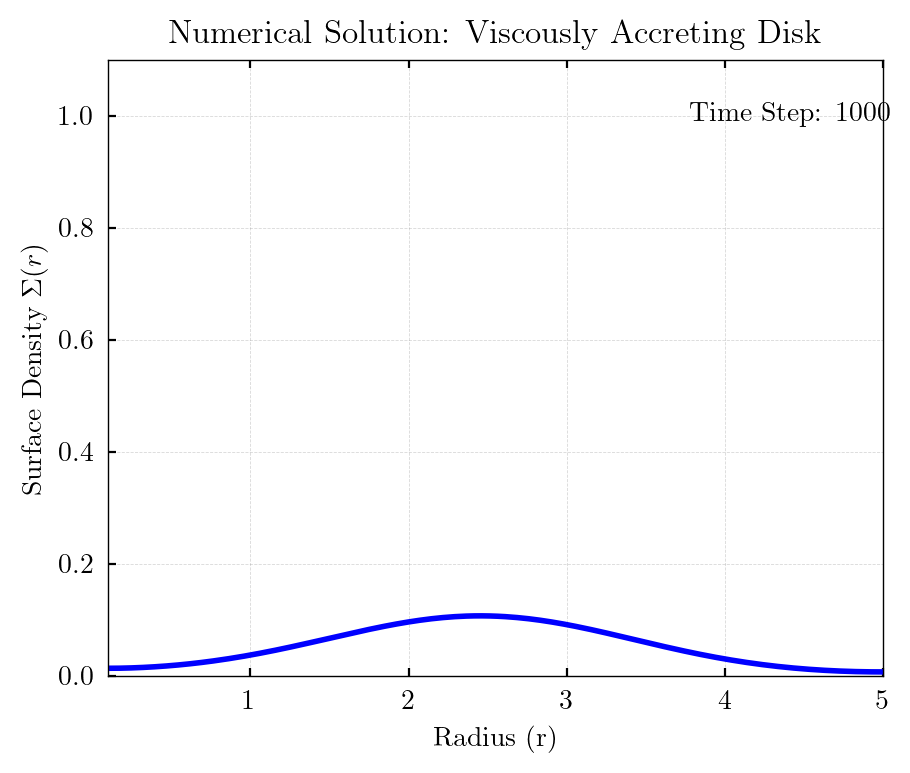

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.linalg import solve_banded

# --- 1. Grid and Parameters ---
nu = 0.01          # Constant viscosity
r_min, r_max = 0.1, 5.0
N = 200            # Number of spatial grid points
dr = (r_max - r_min) / (N - 1)
r = np.linspace(r_min, r_max, N)

dt = 0.005         # Timestep
n_steps = 1000     # Total time steps

# Advection velocity and Diffusion coeff
u = -4.5 * nu / r  # u(r) = -9*nu / (2r)
D = 3.0 * nu

# --- 2. Initial Condition ---
# Sharp Gaussian centered in the simulation box
r0 = (r_max + r_min) / 2.0
sigma_0 = 0.1
Sigma = np.exp(-0.5 * ((r - r0) / sigma_0)**2)

# --- 3. Implicit Diffusion Matrix Setup ---
# Solves: Sigma^{n+1} - dt * D * Laplacian(Sigma^{n+1}) = Sigma^*
alpha = D * dt / (dr**2)

# Tridiagonal matrix diagonals
lower = -alpha * np.ones(N)
main  = (1.0 + 2.0 * alpha) * np.ones(N)
upper = -alpha * np.ones(N)

# Outflow Boundary Conditions for implicit step (Neumann, zero gradient)
# Sigma[0] = Sigma[1] -> main[0] = 1 + alpha
main[0] = 1.0 + alpha
main[-1] = 1.0 + alpha

banded_matrix = np.array([upper, main, lower])

# --- 4. Simulation Loop with Operator Splitting ---
Sigma_history = [Sigma.copy()]

for step in range(n_steps):
    # Step A: Advection using Lax-Friedrichs
    Sigma_star = np.copy(Sigma)
    
    # Interior points update
    Sigma_star[1:-1] = 0.5 * (Sigma[2:] + Sigma[:-2]) - \
                       (dt / (2 * dr)) * u[1:-1] * (Sigma[2:] - Sigma[:-2])
    
    # Advection Outflow Boundaries
    Sigma_star[0] = Sigma_star[1]
    Sigma_star[-1] = Sigma_star[-2]
    
    # Step B: Diffusion using Implicit Method
    # Solve banded system: A * Sigma_new = Sigma_star
    Sigma_new = solve_banded((1, 1), banded_matrix, Sigma_star)
    
    Sigma = Sigma_new.copy()
    
    # Save frames for animation
    if step % 10 == 0:
        Sigma_history.append(Sigma.copy())

# --- 5. Animation ---
fig, ax = plt.subplots(figsize=(5, 4))
line, = ax.plot(r, Sigma_history[0], color='blue', lw=2)
ax.set_xlim(r_min, r_max)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Radius (r)')
ax.set_ylabel(r'Surface Density $\Sigma(r)$')
ax.set_title('Numerical Solution: Viscously Accreting Disk')
ax.grid(True, alpha=0.3)

time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)

def animate(i):
    line.set_ydata(Sigma_history[i])
    time_text.set_text(f'Time Step: {i*10}')
    return line, time_text

ani = animation.FuncAnimation(fig, animate, frames=len(Sigma_history), 
                              interval=50, blit=True)

# To save as mp4, uncomment the line below (requires ffmpeg)
ani.save('accretion_disk.mp4', writer='ffmpeg', fps=45)

plt.show()